In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

import torch
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers, metrics 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.utils import class_weight

import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

#Check for gpu connections for spacy and tensorflow
assert torch.cuda.is_available() == True
assert len(tf.config.list_physical_devices('GPU')) == 1

In [ ]:
#Read in Data
df = pd.read_csv('data/movie_train.csv', index_col = 0)
holdout_df = pd.read_csv('data/movie_test.csv', index_col = 0)

#Dependent/independent split
X = df['Plot']
y = df['Genre']

In [9]:
#Gather stop words, punctuation, numbers for removal
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuation = [*string.punctuation , *[str(x) for x in list(range(0,10))]]

#Ensure spacy utilizes gpu over cpu
spacy.prefer_gpu()
#Load spacy
nlp = spacy.load('en_core_web_trf')

#Define spacy tokenizer
def spacy_tok(text):
    '''
    Remove punctuation, character names, and pronouns before
    lemmatize words and remove stop words
    '''
    doc = ''.join([x for x in text if x not in punctuation])
    toks = nlp(doc)
    toks = [word for word in toks if word.pos_ != 'PROPN' and word.pos_ != 'PRON']
    toks = [word.lemma_.lower().strip() for word in toks]
    toks = [word for word in toks if word not in stop_words]
    return toks

In [10]:
#Instantiate vectorizer
tfidf = TfidfVectorizer(tokenizer = spacy_tok,
                        sublinear_tf = True,
                        max_df = .8,
                        min_df = 10,
                        ngram_range = (1, 3))

In [11]:
#Tokenize/Vectorize data
X = tfidf.fit_transform(X).toarray()
holdout = tfidf.transform(holdout_df['Plot']).toarray()

#Encode target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [12]:
#Gather class weights to address class imbalance in Keras model
class_weights = dict(zip(np.unique(y),
                         class_weight.compute_class_weight('balanced',
                                                           np.unique(y),
                                                           y)
                        )
                    )

In [13]:
#Configure tensorflow gpu usage
config = ConfigProto()

#gpu usage cap
#config.gpu_options.per_process_gpu_memory_fraction = .8

#Allow tensorflow to vary gpu usage
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
num = 100
batch_size = 500
#Configure optimzer learning rate
opt = tf.keras.optimizers.Adamax(learning_rate=0.00075)

#Instantiate Keras model
model = Sequential()
model.add(Dense(num*2, activation = 'relu', input_dim = X.shape[1]))
model.add(Dropout(0.6))
model.add(Dense(num/2, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation = 'softmax'))

#Compile/fit model
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics = [metrics.sparse_categorical_accuracy])

results = model.fit(X, y,
                    epochs = 170,
                    batch_size = batch_size,
                    validation_split = 0,
                    shuffle = True,
                    class_weight = class_weights
                   )

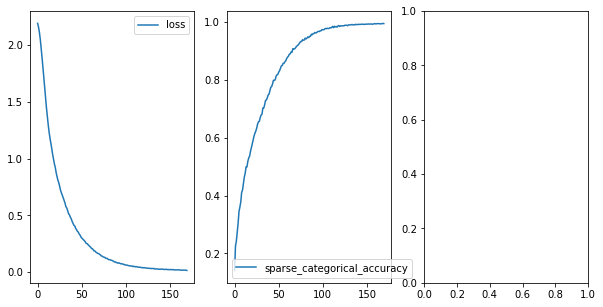

In [22]:
#Gather results
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['sparse_categorical_accuracy']

#Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='sparse_categorical_accuracy');

In [24]:
#Predict on holdout set
predictions = model.predict(holdout)

#Inverse label encoding and create dataframe
predictions = pd.DataFrame(encoder.inverse_transform(predictions.argmax(axis=1)))
#Set index for predictions
predictions.index = holdout_df.index
#Export results
predictions.to_csv('data/nlp_preds_isana_mizuma.csv', index = True)